In [366]:
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import unquote
from tqdm import tqdm 
from scipy.stats import chi2_contingency

dataFolder = '../Data/wikispeedia_paths-and-graph/'
articlesDf = pd.read_csv(dataFolder+ 'articles.tsv')
articlesDf = articlesDf.iloc[10:]
articlesSeries  = pd.Series(articlesDf.index.map(lambda x : x[0])).map(lambda y : unquote(y,'utf-8'))
#articlesSeries.head(10)

linksDf = pd.read_csv(dataFolder + 'links.tsv', header=11, sep = '\t')
linksDf.columns = ['Elements','links']
linksDf['Elements'] = linksDf['Elements'].map(lambda x : unquote(x, 'utf-8'))
linksDf['links'] = linksDf['links'].map(lambda x : unquote(x, 'utf-8'))
#linksDf.reset_index()

categoriesDf = pd.read_csv(dataFolder + 'categories.tsv', header=11, sep= '\t')
categoriesDf.index = categoriesDf.index.map(lambda x : unquote(x,'utf-8'))
categoriesDf.columns = ['categories']
#categoriesDf

paths_finishedDf= pd.read_csv(dataFolder + 'paths_finished.tsv', header=15, sep= '\t')
paths_finishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'rating']
#paths_finishedDf

paths_unfinishedDf= pd.read_csv(dataFolder + 'paths_unfinished.tsv', header=16, sep= '\t')
paths_unfinishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'target', 'type']
#paths_unfinishedDf

people_skin_color = pd.read_csv(dataFolder + 'people_with_skin_color.tsv', header=1, sep= '\t' )
people_skin_color.columns = ['Category', 'People', 'Skin Color']
people_skin_color['People'] = people_skin_color['People'].map(lambda x : unquote(x, 'utf-8'))
people_skin_color.reset_index()

#We change how some names are wrote so that there are similar to the names in in paths_finishedDf and paths_unfininishedDf 
people_skin_color['People'] = people_skin_color['People'].replace('Adolf Hitler', 'Adolf_Hitler')
#people_skin_color

1. Distribution of articles in each categories 


The dataset 'categories' contains main categories and then sub-categories. We will focus on main categories.

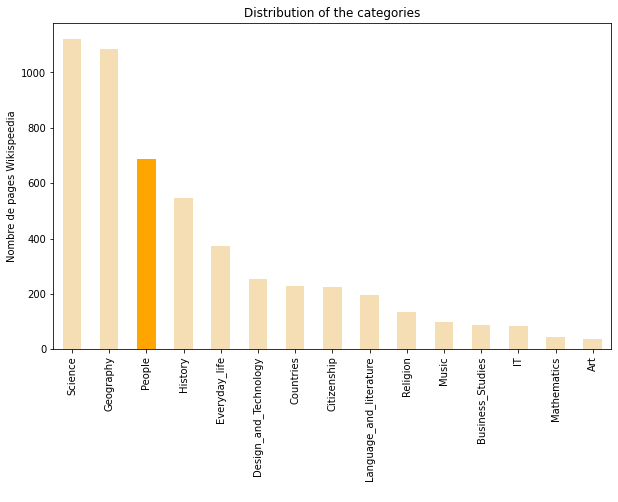

In [367]:
categories_details = categoriesDf["categories"].str.split(".", expand=True)

#keep only the main category
categories = categories_details[1]
categories = pd.DataFrame(categories)
categories = categories.rename(columns = {1 : 'Main Categories'})
categories_distribution=categories['Main Categories'].value_counts()

#Vizualise the distribution 
plt.figure(figsize=(10, 6))  
colors = ['wheat' if cat != 'People' else 'orange' for cat in categories_distribution.index]
categories_distribution.plot(kind='bar', color=colors)
plt.title('Distribution of the categories')
plt.xlabel(' ')
plt.ylabel('Nombre de pages Wikispeedia')
plt.show()

People is the third category containing the bigger amount of articles (around 700 articles). We will know focus on this category and used our new dataset 'people_with_skin_color.tsv'

2. The ethnics distribution whitin people articles

To continue, we will focus on the ethnics distribution whithin the people articles. 

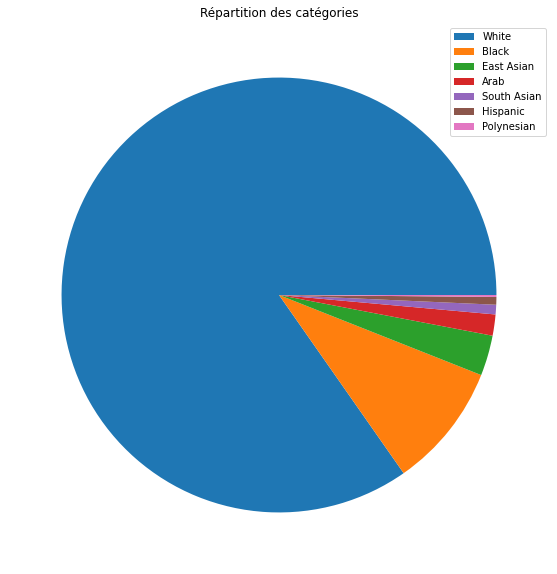

In [368]:
people_color =  pd.concat([people_skin_color, people_skin_color['Category'].str.split(".", expand=True)], axis=1)
people_color = people_color.drop(columns = ['Category', 0, 1])
people_color = people_color.rename(columns = {1 : 'Categories'})

unique_color=people_color['Skin Color'].unique()
rename = {
    'Blanc' : 'White',
    'Peau plus foncée' : 'Black',
    'Peau brune' : 'Black',
    'Peau plus foncée (Aborigène australien)' : 'Black',
    'Peau plus foncée (Asiatique)' : 'East Asian', 
    'Peau plus foncée (Moyen-Orient)' : 'Arab',
    'Peau plus foncée (Polynésien)' : 'Polynesian',
    'Peau plus foncée (Sherpa/Népalais)' : 'South Asian', 
    'Peau plus foncée (Ascendance africaine partielle)' : 'Black', 
    'Peau plus foncée (Indien)' : 'South Asian',
    'Peau plus foncée (Berbère)' : 'Arab',
    'Peau plus foncée (Arabe)' : 'Arab',
    'Peau plus foncée (Tibétain)' : 'East Asian',
    'Peau plus foncée (Persan)' : 'Arab',
    'Peau plus foncée (Juif)' : 'Arab', 
    'Peau plus foncée (Somalienne)' : 'Black', 
    'Peau plus foncée (Mixte)' : 'Black',
    'Peau plus foncée (Hispanique)' : 'Hispanic', 
    'Peau plus foncée (Indonésien)' : 'East Asian', 
    'Peau plus foncée (Japonais)' : 'East Asian',
    'Peau plus foncée (Vietnamien)' : 'East Asian', 
    'Peau plus foncée (Indienne)' : 'South Asian', 
    'Peau brune (Indien)' : 'South Asian',
    'Peau plus foncée (Palestinien)' : 'Arab',
    'Peau brune (Pakistano-Indien)' : 'South Asian', 
    "Blanc (D'origine libanaise)": 'White', 
    'Peau plus foncée (Brésilien)' : 'Hispanic'
}
people_color['Skin Color'] = people_color['Skin Color'].replace(rename)
people_color_dist=people_color['Skin Color'].value_counts()

#Vizualise the data
plt.figure(figsize=(10, 10))  
plt.pie(people_color_dist)
plt.title('Répartition des catégories')
plt.legend(people_color_dist.index)
plt.show()



So the distribution of white people is way more bigger than the representation of the other ethnics groups. Wikispeedia contains more article about white personalities. This already show the inequal representation of the different ethnics groups within the game.

3. Extract the pathways where people are the final target 

So, we will look closely to the pathways where the target articles is a white people.

In [369]:
#Create a dataframe with the path decompose (each cells represents one article of the paths)
path =  paths_finishedDf['path'].str.split(";", expand=True)

#creat a dataframe containing only the people name
people_name= people_color['People']

In [370]:
# Convert 'people_name' to a set for faster lookups
people_set = set(people_name.tolist())

# Create a boolean mask indicating if any cell value in each row is in 'people_set'
mask = path.isin(people_set)

# Use any(axis=1) to check if any cell in a row contains a value from 'people_set'
rows_with_name = mask.any(axis=1)

# Filter the DataFrame to get the rows where at least one cell has a value from 'people_set'
people_path = path[rows_with_name]

In [371]:
# Find all the path containing a people as final target and exctrant the starting article corresponding to it 
people_target_finish = []
index_target = []

start_finish= []

for index, row in tqdm(people_path.iterrows()):
    no_none_value = [value for value in row if value != None]
    if no_none_value[-1] in people_name.tolist() :
        people_target_finish.append(no_none_value[-1])
        index_target.append(index)
        start_finish.append(no_none_value[0])


print(people_target_finish)
print(index_target)
print(start_finish)

3161it [00:00, 7771.91it/s]

['Voltaire', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Euclid', 'Euclid', 'Euclid', 'Adolf_Hitler', 'Heraclius', 'Jesus', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Claudius', 'H.D.', 'Confucius', 'Confucius', 'Confucius', 'Confucius', 'Confucius', 'Confucius', 'Confucius', 'Confucius', 'Buddha', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Jesus', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitler', 'Adolf_Hitle

In [372]:
white_people = people_color[people_color['Skin Color'] == 'White']['People'].tolist()
arab_people = people_color[people_color['Skin Color'] == 'Arab']['People'].tolist()
black_people = people_color[people_color['Skin Color'] == 'Black']['People'].tolist()
east_asian_people = people_color[people_color['Skin Color'] == 'East Asian']['People'].tolist()

white_index =[]
arab_index =[]
black_index =[]
east_asian_index =[]

for i in range(0, len(index_target)):
    if people_target_finish[i] in white_people :
        white_index.append(index_target[i])

    if people_target_finish[i] in east_asian_people :
        east_asian_index.append(index_target[i])

    if people_target_finish[i] in arab_people:
        arab_index.append(index_target[i])

    if people_target_finish[i] in black_people :
        black_index.append(index_target[i])


In [373]:
#Count how many times each people are target
people_target_count = pd.Series(people_target_finish).value_counts().reset_index()
people_target_count.columns =['People', 'Count']

#Merge with the original color_people dataframe to have the informations on the ethnicity and category
people_target_df = people_target_count.merge(people_color)
people_target_df

,People,Count,Skin Color,2
0,Adolf_Hitler,603,White,Political_People
1,Jesus,197,Arab,Religious_figures_and_leaders
2,Socrates,46,White,Philosophers
3,Muhammad,43,Arab,Religious_figures_and_leaders
4,Buddha,33,East Asian,Religious_figures_and_leaders
5,Aristotle,31,White,Philosophers
6,Confucius,28,East Asian,Philosophers
7,Hippocrates,25,White,Human_Scientists
8,Plato,22,White,Philosophers
9,Pythagoras,20,White,Mathematicians


No handles with labels found to put in legend.


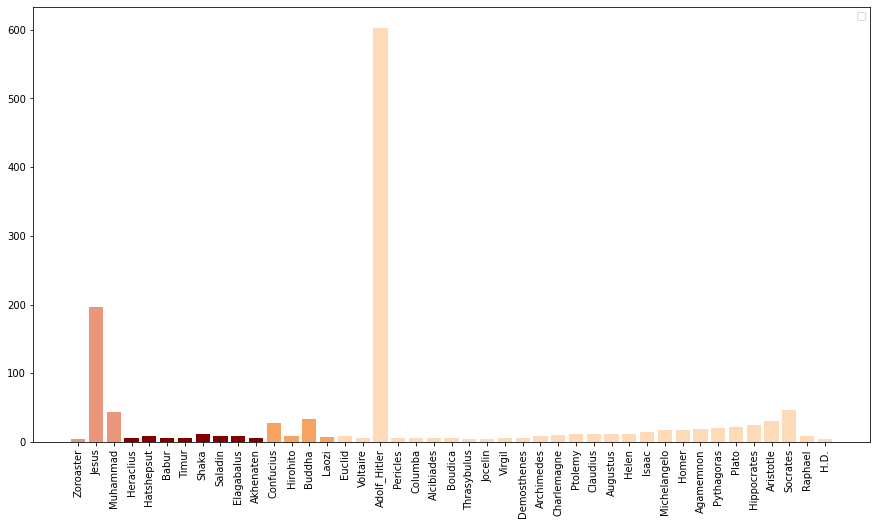

In [374]:
#Vizualise the data 
people_target_df = people_target_df.sort_values(by = 'Skin Color')
couleur = ['darksalmon' if ethnic == 'Arab' else 'maroon' if  ethnic == 'Black' else 'sandybrown' if ethnic == 'East Asian' 
           else 'peachpuff' for ethnic in people_target_df['Skin Color']]

plt.figure(figsize=(15, 8)) 
plt.bar(people_target_df['People'], people_target_df['Count'], color = couleur)
plt.xticks(rotation='vertical')
plt.legend()

#AFFICHER LA LEGENDE 

So we clearly see, that white people dominate the target of the game with in second positions black people and then east asian an arab people. Some ethnics groups are not even represented in the target such as south east people. One person is highly target it is Jesus.  


4. Study of the difficulty depending on the ethnics groups of the target

In [375]:
#Create dataframe containing the games informations for each ethnics groups target
target_white_path = paths_finishedDf.loc[white_index]
target_arab_path = paths_finishedDf.loc[arab_index]
target_black_path = paths_finishedDf.loc[black_index]
target_eastasian_path = paths_finishedDf.loc[east_asian_index]


In [376]:
#Mean difficulty (rated by the players)
white_mean_diff = target_white_path['rating'].mean(skipna = True)
arab_mean_diff = target_arab_path['rating'].mean(skipna = True)
black_mean_diff = target_black_path['rating'].mean(skipna = True)
eastasian_mean_diff = target_eastasian_path['rating'].mean(skipna = True)

print(white_mean_diff)
print(arab_mean_diff)
print(black_mean_diff)
print(eastasian_mean_diff)

1.9979253112033195
1.8130081300813008
2.5675675675675675
2.0


Looking at this first estimation, it is difficult to say if white people target's path are less difficult than the others. Indeed, path with for target black people seems the more difficult whereas the one targeting arab people are the easier. So those results can't lead to a conclusion.

In [377]:
#Mean duration time for the different ethnics groups target
white_mean_duration= target_white_path['durationInSec'].mean(skipna = True)
arab_mean_duration = target_arab_path['durationInSec'].mean(skipna = True)
black_mean_duration = target_black_path['durationInSec'].mean(skipna = True)
eastasian_mean_duration = target_eastasian_path['durationInSec'].mean(skipna = True)

print(white_mean_duration)
print(arab_mean_duration)
print(black_mean_duration)
print(eastasian_mean_duration)

107.95454545454545
93.32377049180327
152.98245614035088
136.3116883116883


The mean duration of the games shows thats the shortest games are the one where arab people are target. This result is consistent with the previous computation of mean difficulty, even if it was quite unexpected. It is difficult to draw conclusions from the other results.

A good way to compare the difficulty between the different pathway would be to compare the victory and the defeat games. 

In [378]:
unfinished_target_people = paths_unfinishedDf[paths_unfinishedDf['target'].isin(people_name)]

index_target_unfinish = unfinished_target_people.index
target_unfinish = unfinished_target_people['target']
print(target_unfinish)

unfinish = unfinished_target_people['target'].value_counts().reset_index()
unfinish.columns = ['People', 'Count']

#Merge with the original color_people dataframe to have the informations on the ethnicity and category
people_target_unfinish = unfinish.merge(people_color)


83         Archimedes
338             Isaac
481           Boudica
498       Hippocrates
630      Adolf_Hitler
             ...     
24114           Jesus
24338      Archimedes
24423     Hippocrates
24425         Boudica
24433        Muhammad
Name: target, Length: 300, dtype: object


No handles with labels found to put in legend.


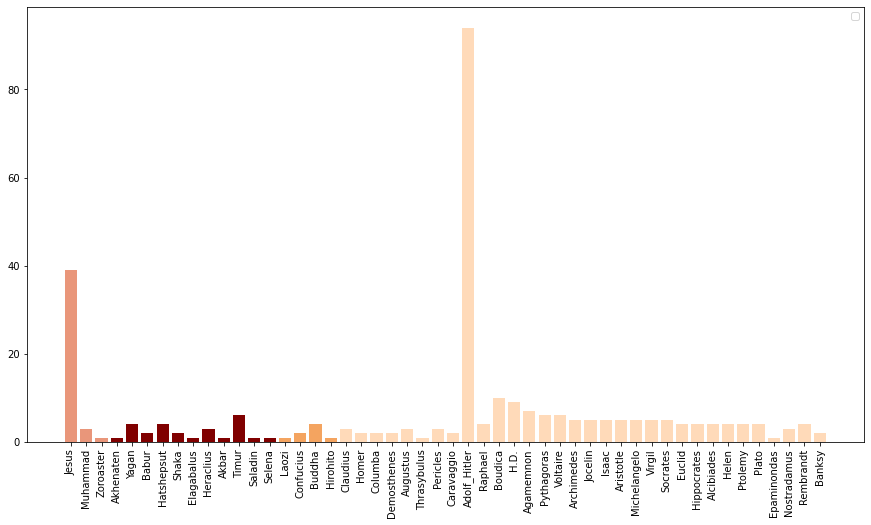

In [379]:
#Vizualise the data 
people_target_unfinish = people_target_unfinish.sort_values(by = 'Skin Color')
couleur = ['darksalmon' if ethnic == 'Arab' else 'maroon' if  ethnic == 'Black' else 'sandybrown' if ethnic == 'East Asian' 
           else 'peachpuff' for ethnic in people_target_unfinish['Skin Color']]

plt.figure(figsize=(15, 8)) 
plt.bar(people_target_unfinish['People'], people_target_unfinish['Count'], color = couleur)
plt.xticks(rotation='vertical')
plt.legend()

So the distribution is quite the same for victory and defeat. Indeed, few more names appears for black people in the defeat. So at first sight the ethnicity does not seems to impact the finality of the games. But, this is just superficial result, we need to go further in details and in statistics test to take conclusion.

There are some CONFOUNDERS that can affect the finality of the games to victory or defeat : 
- players skills 
- length of the shortest path
- difficulty of the propose games (source and target)

We need to fixed those confounders to compute a better analysis.  

**1st possibility** : Compare path with the same beginning article and target article in paths_finished and paths_unfinished. 

**2nd possibility** : Compare only the pathways realised from the same source.

**3rd possibility** : Compare only the pathways realised from the same source and with the same shortest path length.

**1ST POSSIBILITY**

In [380]:
#Create a dataframe with the path unfinished decompose (each cells represents one article of the paths)
path_unfinished=  paths_unfinishedDf['path'].str.split(";", expand=True)

In [381]:
#Only keep the line of the dataframe unfinish which target a person 
unfinish_target_people = path_unfinished.loc[index_target_unfinish]

#extract the start article of this dataframe
start_unfinish= unfinish_target_people[0]
print(start_unfinish)

83                        Europe
338                        Qatar
481           Bottlenose_Dolphin
498            Tourette_syndrome
630                     Hydrogen
                  ...           
24114               Adolf_Hitler
24338     Southern_United_States
24423    List_of_Asian_countries
24425      To_Kill_a_Mockingbird
24433             Carbon_dioxide
Name: 0, Length: 300, dtype: object


In [382]:
#Create two dataframe : containing start and end of pathway which target people for defeat and victory
defeat = pd.concat([start_unfinish, target_unfinish], axis=1)
victory = pd.concat([pd.Series(start_finish), pd.Series(people_target_finish)], axis=1)

defeat = defeat.rename(columns= {0 : 'start'})
victory = victory.rename(columns= {0 : 'start', 1 : 'target'})

So now, we have dataframe for victory and defeat where the final article is People. As many confounders can affect the finality of the game, it can be a good solution to select the data with the same characteristics. 
A solution would be to keep only the data with the same start and target and count the victory and defeat in each case

In [383]:
#Creating a dataframe with the similar games  won and loose and the amount of victory and defeat in those games.
#Similar games = games with the same start and the same target

df = pd.DataFrame()
df['path'] = defeat.apply(lambda row : '-'.join(row.values.astype(str)), axis =1)
defeat_count= df['path'].value_counts().reset_index()
defeat_count.columns = ['Start-Target', 'Count']

df1 = pd.DataFrame()
df1['path'] = victory.apply(lambda row : '-'.join(row.values.astype(str)), axis =1)
victory_count= df1['path'].value_counts().reset_index()
victory_count.columns = ['Start-Target', 'Count']

similar_game = pd.merge(victory_count, defeat_count, on = ['Start-Target'])
similar_game = similar_game.rename(columns= {'Count_x' : 'Victory', 'Count_y' : 'Defeat'})
similar_game = pd.concat([similar_game['Start-Target'].str.split("-", expand=True), similar_game],axis = 1)
similar_game = similar_game.drop(columns='Start-Target')
similar_game = similar_game.rename(columns={0 : 'Start', 1 : 'People'})
similar_game = similar_game.merge(people_color)
similar_game = similar_game.rename(columns={'People' : 'target', 2 : 'Category'})

similar_game

,Start,target,Victory,Defeat,Skin Color,Category
0,Bird,Adolf_Hitler,107,22,White,Political_People
1,Flower,Adolf_Hitler,51,4,White,Political_People
2,Cat,Adolf_Hitler,27,7,White,Political_People
3,Jesus,Adolf_Hitler,24,5,White,Political_People
4,California,Adolf_Hitler,21,5,White,Political_People
...,...,...,...,...,...,...
85,Stone_Age,H.D.,1,4,White,Writers_and_critics
86,Aircraft,Heraclius,1,1,Black,Historical_figures
87,Ichthyosaur,Saladin,1,1,Black,Historical_figures
88,Tigris,Laozi,1,1,East Asian,Philosophers


In [384]:
others = similar_game[similar_game['Skin Color'] != 'White']
white = similar_game[similar_game['Skin Color'] != 'Arab']
white = white[white['Skin Color'] != 'Black']
white = white[white['Skin Color'] != 'East Asian']

vic_white = white['Victory'].sum()
def_white = white['Defeat'].sum()
vic_others = others['Victory'].sum()
def_others = others['Defeat'].sum()
print(vic_white)
print(def_white)
print(vic_others)
print(def_others)

410
130
131
45


<AxesSubplot:xlabel='Target'>

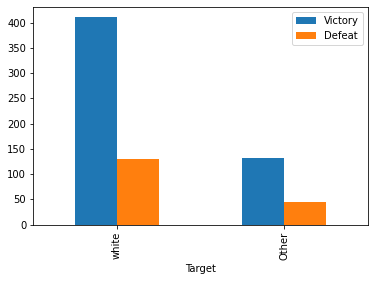

In [385]:
result = pd.DataFrame({
    'Target' : ['white', 'Other'],
    'Victory' : [vic_white, vic_others],
    'Defeat' : [def_white, def_others]
})

result.plot(x='Target', y=['Victory', 'Defeat'], kind="bar")

To know if the target person ethnics group has an impact on the result of the game (victory or defeat), we can use a statistic test to compare the victory between both groups (white and others). For example, we can do a Chi-2 test with the following null hypothesis : 
- H0 : There is no significant differences in victories dependanding on the target people (white or others)' 
- H1 : There is a significant differences in victories depending on the target people (white or others)'

|  | Victory | Defeat |
|-----------|-----------|-----------|
| Target White People  | 410    | 130   |
| Target Other People   | 131    | 45    |

In [386]:
#chi2 test
contingency_table = [[vic_white, def_white], [vic_others, def_others]]

_, p_value, _, _ = chi2_contingency(contingency_table)
print(p_value)

0.7644989409512375


p-value>0.05,  so we can't reject the null hypothesis 


**2ND POSSIBILITY :** 

So, we can change the constraint and  increase it in stages by starting with a small and easy one. 
- Considering all the path that target a people take paths with the same source.  


So we need to control the confounders, to do so we have to match the data by creating pairs of paths to compare them. The target articles of the pairs are a white people article and an others ethnics groups article. The matching has to constraint following those parameters : 

- starting a path at the same source article (minimum requirement of matching)  


In [387]:
#Create a dataframe with colonne : Start / Target / Target's Ethnicity / Victory or Defeat
defeat = defeat.rename(columns={'target' : 'People'})
defeat = pd.merge(defeat, people_color, on='People')
defeat = defeat.rename(columns= {'People' : 'target', 2 :'Category', })

victory = victory.rename(columns={'target' : 'People'})
victory = pd.merge(victory, people_color, on='People')
victory = victory.rename(columns= {'People' : 'target', 2 :'Category', })


In [388]:
defeat['Result'] = 'defeat'
victory['Result'] = 'victory'
df = pd.concat([defeat, victory], axis = 0)

In [389]:
#Create a function to match the data with the same source
def matching(df):
    white_skin = df[df['Skin Color'] == 'White']
    other_ethnics = df[df['Skin Color'] != 'White']

    matched_pairs = []
    result =[]
    for start in df['start'].unique():
        white_targets = white_skin[white_skin['start'] == start]['target'].tolist()
        non_white_targets = other_ethnics[other_ethnics['start'] == start]['target'].tolist()

        result_white = white_skin[white_skin['start'] == start]['Result'].tolist()
        result_others = other_ethnics[other_ethnics['start'] == start]['Result'].tolist()
        # Créer des paires avec un élément de 'target' avec 'skin color' blanc et un avec un autre 'skin color'
        for w in white_targets:
            for nw in non_white_targets:
                matched_pairs.append((start, w, nw))
        
        for i in result_white : 
            for j in result_others :
                result.append((start, i, j))
    
    # Créer un DataFrame avec les paires créées
    matched= pd.DataFrame(matched_pairs, columns=['start', 'white_skin_target', 'other_ethnics_target'])
    result = pd.DataFrame(result, columns=['start', 'result_white_target', 'result_other_target'])

    matched_df = pd.concat([matched, result], axis=1)
    matched_df = matched_df.loc[:,~matched_df.columns.duplicated()]
    return matched_df

# Utiliser la fonction sur votre DataFrame
# df est votre DataFrame initial avec les colonnes start, target, Skin Color, Category
matched_pairs_df= matching(df)
matched_pairs_df

,start,white_skin_target,other_ethnics_target,result_white_target,result_other_target
0,Reptile,Archimedes,Jesus,defeat,defeat
1,Reptile,Archimedes,Jesus,defeat,victory
2,Reptile,Archimedes,Jesus,defeat,victory
3,Reptile,Archimedes,Jesus,defeat,victory
4,Reptile,Archimedes,Jesus,defeat,victory
...,...,...,...,...,...
572,Golden_Eagle,Euclid,Buddha,victory,victory
573,Radio_telescope,Charlemagne,Buddha,victory,victory
574,Grand_Central_Terminal,Plato,Buddha,victory,victory
575,England,Charlemagne,Muhammad,victory,victory


In [390]:
#Count the victory and the defeat depending on the target. 
target_white = matched_pairs_df['result_white_target'].value_counts()
target_others = matched_pairs_df['result_other_target'].value_counts()

print(target_white)
print(target_others)

result_white_target
victory    507
defeat      70
Name: count, dtype: int64
result_other_target
victory    480
defeat      97
Name: count, dtype: int64


<AxesSubplot:xlabel='Target'>

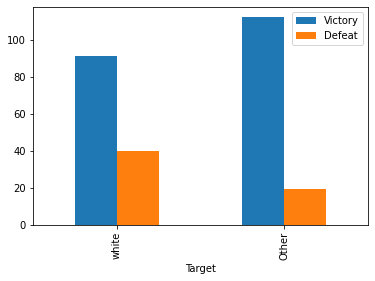

In [391]:
#Vizualise the data
victory_white = 91
defeat_white = 40
victory_other = 112
defeat_other = 19

result = pd.DataFrame({
    'Target' : ['white', 'Other'],
    'Victory' : [victory_white, victory_other],
    'Defeat' : [defeat_white, defeat_other]
})

result.plot(x='Target', y=['Victory', 'Defeat'], kind="bar")

To know if the target person ethnics group has an impact on the result of the game (victory or defeat), we can use a statistic test to compare the victory between both groups (white and others). For example, we can do a Chi-2 test with the following null hypothesis : 
- H0 : There is no significant differences in victories dependanding on the target people (white or others)' 
- H1 : There is a significant differences in victories depending on the target people (white or others)'

|  | Victory | Defeat |
|-----------|-----------|-----------|
| Target White People  | 507    | 70    |
| Target Other People   | 480    | 97    |

In [392]:
#chi2 test 

contingency_table = [[victory_white, defeat_white], [victory_other, defeat_other]]

_, p_value, _, _ = chi2_contingency(contingency_table)
print(p_value)

0.003095843369012257


The p-value < 0.05, so we reject the null hypothesis in favour of the alternative hypothesis. 
Indeed, target the other ethnics groups seems to lead more to the victory. This result is quite unexpected. Maybe we can refine our analysis by adding constraint on the confounders such as keeping only the data with the same source and the same shortest path length.